In [1]:
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

In [2]:
from pyglmnet import GLM

spike_history=None
cov_history=None
random_state=0
window=0
n_filters=0
max_time=0
n_every=1
verbose=1
is_ensemble=False
first_order_models=None

In [3]:
params={'distr':'gaussian', 
        'alpha':0.1, 
        'tol':1e-8, 
        'reg_lambda':np.logspace(np.log(0.05), np.log(0.0001), 10, base=np.exp(1)), 
        'learning_rate':2, 
        'max_iter':10000, 
        'eta':2.0}

In [4]:
model = GLM(**params)

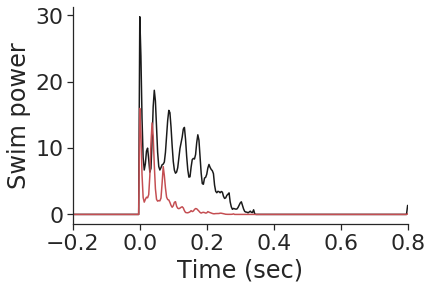

In [5]:
nfish = 1
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

trial_valid = np.ones(len(swim_starts)).astype('bool')
for n, n_swim in enumerate(swim_starts[:-1]):        
    # examine the swim with short inter-swim-interval
    if swim_starts[n+1] - n_swim < t_sig:    
        trial_valid[n] = False


p_swim = l_swim+r_swim
plt.plot(t_label, p_swim[(task_period==1) & trial_valid, :].mean(axis=0), '-k')
plt.plot(t_label, p_swim[(task_period==2) & trial_valid, :].mean(axis=0), '-r')
plt.ylabel('Swim power')
plt.xlabel('Time (sec)')
plt.xlim([-0.2, 0.8])
sns.despine()
plt.show()

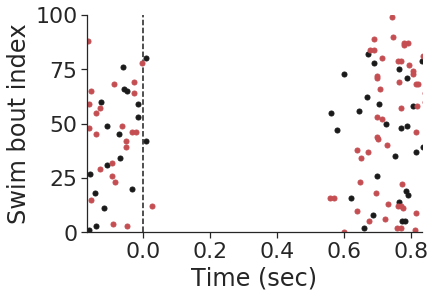

In [6]:
ncell_ = 6
_ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
# trial_valid = _['trial_valid']
sub_swim = _['sub_swim'][ncell_]
spk_swim = _['spk_swim'][ncell_]*300
spk_list = _['raw_spk_swim'][ncell_]

plt_raster(spk_list[(task_period==1) & trial_valid, :], c='k')
plt_raster(spk_list[(task_period==2) & trial_valid, :], c='r')
# plt.title(f'Cell #{n_cell}')
plt.ylabel('Swim bout index')
plt.xlabel('Time (sec)')
plt.xlim([-50/300, 250/300])
# plt.axis('off')
plt.ylim([0, 100])
plt.vlines([0], [0], [320], colors='k', linestyles='--')
sns.despine()

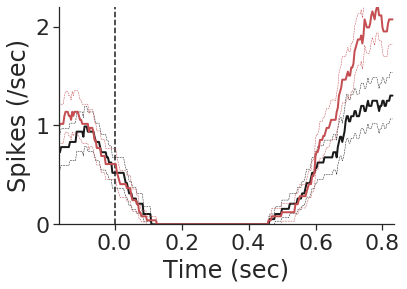

In [7]:
# k_ = gaussKernel(sigma=20)
k_ = boxcarKernel(sigma=60)
# ave_ = spk_list[task_period==1, :].mean(axis=0)*300
ave_ = []
for n_spk in spk_list[(task_period==1) & trial_valid, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-k', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--k', lw=0.5)


ave_ = []
for n_spk in spk_list[(task_period==2) & trial_valid, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-r', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--r', lw=0.5)

plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [0], [2.2], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()

# plt.savefig('../Plots/gain/exp_neuron_act.pdf')

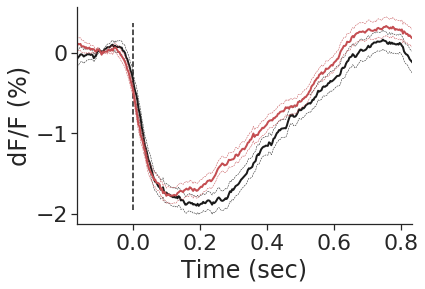

In [8]:
sub_list = sub_swim-sub_swim[:, 70:75].mean(axis=-1, keepdims=True)
t_min = 0
t_max = 450
ave_ = sub_list[(task_period==1) & trial_valid, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[50:(100-t_min)].mean()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-k', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--k', lw=0.5)

ave_ = sub_list[(task_period==2) & trial_valid, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[50:(100-t_min)].mean()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-r', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--r', lw=0.5)

# plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('dF/F (%)')
sns.despine()
# plt.savefig('../Plots/gain/exp_neuron_subvolt.pdf')

In [13]:
trial_valid_fit = trial_valid & ((visu[:,:t_pre-10]<=0).sum(axis=-1)==0)

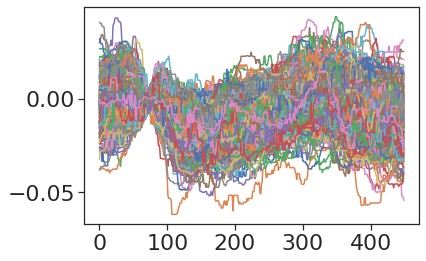

In [15]:
plt.plot(sub_list[trial_valid_fit].T)
plt.show()

In [28]:
Y_dat = []
X_dat = []

for n_, dff_ in enumerate(sub_list):
    if not trial_valid_fit[n_]:
        continue
    spk_ = spk_list[n_]
    swim_ = p_swim[n_]
    visu_ = -visu[n_]
    visu_[visu_<0]=0
    for n_time in range(t_pre, t_pre+240):
        spk_history=spk_[n_time-1:n_time]
        swim_history=swim_[n_time-30:n_time+30]
        visu_pad = 60
        if n_time>120:
            visu_history=visu_[n_time-visu_pad:n_time]
        else:
            visu_history=np.zeros(visu_pad)
        Y_dat.append(dff_[n_time]-dff_[n_time-30])
        X_dat.append(np.r_[-spk_history, -np.sqrt(swim_history)/100, np.sqrt(visu_history)/100])

In [29]:
Y_dat = np.array(Y_dat)
X_dat = np.array(X_dat)

In [30]:
from scipy.optimize import nnls
from sklearn.linear_model import LinearRegression

In [31]:
reg = LinearRegression(fit_intercept=False).fit(X_dat, Y_dat)

In [32]:
w = reg.coef_

In [33]:
w, rnorm = nnls(X_dat, Y_dat)

In [34]:
Y_hat = X_dat.dot(w)

In [35]:
1 - ((Y_dat-Y_hat)**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

0.17507564954069643

In [36]:
1 - ((Y_dat-X_dat[:,:2].dot(w[:2]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

-0.0010646979445037008

In [37]:
1 - ((Y_dat-X_dat[:,2:62].dot(w[2:62]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

0.1648320542628562

In [38]:
1 - ((Y_dat-X_dat[:,62:].dot(w[62:]))**2).sum()/((Y_dat-Y_dat.mean())**2).sum()

0.015940761739877907

Text(0.5, 0, 'time (ms)')

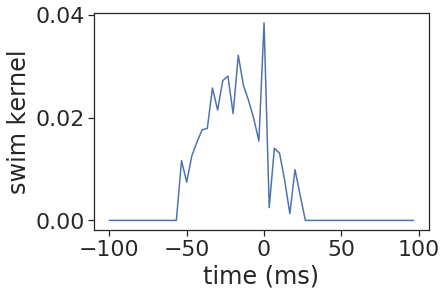

In [45]:
plt.plot(np.arange(-30,30)/300*1000, w[1:61])
plt.ylabel('swim kernel')
plt.xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

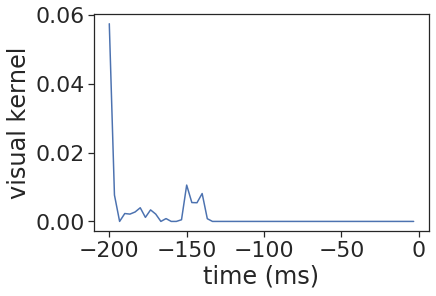

In [48]:
plt.plot(np.arange(-visu_pad,0)/300*1000, w[61:])
plt.ylabel('visual kernel')
plt.xlabel('time (ms)')